In [1]:
pip install kaggle

In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 67 bytes


In [3]:
! kaggle competitions download -c digit-recognizer

test.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau,LearningRateScheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Flatten, BatchNormalization, Activation, MaxPool2D, Dropout, Convolution2D, AveragePooling2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.convolutional import Conv2D
from keras.optimizers import RMSprop, Adam
from keras.preprocessing.image import ImageDataGenerator

In [5]:
! unzip train.csv.zip
! unzip test.csv.zip

Archive:  train.csv.zip
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train.csv               
Archive:  test.csv.zip
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: test.csv                


In [6]:
# Getting our data 
training_data = pd.read_csv('train.csv')
x_test = pd.read_csv('test.csv')

In [7]:
#Spliting the data and normalize the image 
x_train, y_train = training_data.drop(labels = ["label"],axis = 1)/255, training_data["label"]
x_test = x_test/255

In [8]:
#Reshape our data
x_train = x_train.values.reshape(-1,28,28,1)
x_test = x_test.values.reshape(-1,28,28,1)

In [9]:
#Label encoding
y_train = to_categorical(y_train, num_classes = 10)

In [10]:
# Spliting the training and vadlidation set 
X_train, X_val, Y_train, Y_val = train_test_split(x_train, y_train, test_size=0.1)

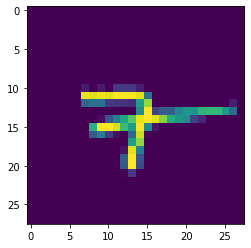

In [11]:
# An example
plt.imshow(X_train[1][:,:,0])

DATA AUGMENTATION 

In [12]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

CNN ARCHITECTURE 

In [13]:
model = Sequential()
    
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

In [14]:
# Define the optimizer
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)

In [15]:
# Compile model 
model.compile(loss="categorical_crossentropy", optimizer = Adam(lr=1e-4), metrics=['accuracy'])

In [16]:
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=86),
                              epochs = 30, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // 86
                              , callbacks=[annealer])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
439/439 - 249s - loss: 0.4236 - accuracy: 0.8635 - val_loss: 0.0668 - val_accuracy: 0.9805
Epoch 2/30
439/439 - 247s - loss: 0.1348 - accuracy: 0.9597 - val_loss: 0.0556 - val_accuracy: 0.9852
Epoch 3/30
439/439 - 247s - loss: 0.0992 - accuracy: 0.9704 - val_loss: 0.0433 - val_accuracy: 0.9869
Epoch 4/30
439/439 - 247s - loss: 0.0837 - accuracy: 0.9752 - val_loss: 0.0370 - val_accuracy: 0.9898
Epoch 5/30
439/439 - 246s - loss: 0.0666 - accuracy: 0.9800 - val_loss: 0.0362 - val_accuracy: 0.9910
Epoch 6/30
439/439 - 247s - loss: 0.0608 - accuracy: 0.9818 - val_loss: 0.0358 - val_accuracy: 0.9900
Epoch 7/30
439/439 - 247s - loss: 0.0533 - accuracy: 0.9841 - val_loss: 0.0334 - val_accuracy: 0.9902
Epoch 8/30
439/439 - 246s - loss: 0.0501 - accuracy: 0.9847 - val_loss: 0.0303 - val_accuracy: 0.9921
Epoch 9/30
439/439 - 246s - loss: 0.0466 - accuracy: 0.9865 - val_loss: 0.0414 - val_accuracy: 0.9890
Epoch 10/30
439/439 - 246s - loss: 0.0418 - accuracy: 0.9875 - val_loss: 0.0361 - 

In [17]:
# Saving the model weight
model.save('mnist_classifier.h5')

In [18]:
# Predict the result
results = model.predict(x_test)
# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

In [23]:
# Submit the result 
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("cnn_mnist_datagen.csv",index=False)

Installing the TensorFlow.js Converter 

In [24]:
!apt-get install python3-venv

!python -m venv .tensorflowjs-env

!source .tensorflowjs-env/bin/activate
!pip install tensorflowjs
!deactivate

!source .tensorflowjs-env/bin/activate
!tensorflowjs_converter --input_format keras mnist_classifier.h5 .
!deactivate

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  python-pip-whl python3.6-venv
The following NEW packages will be installed:
  python-pip-whl python3-venv python3.6-venv
0 upgraded, 3 newly installed, 0 to remove and 15 not upgraded.
Need to get 1,660 kB of archives.
After this operation, 1,902 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 python-pip-whl all 9.0.1-2.3~ubuntu1.18.04.4 [1,653 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 python3.6-venv amd64 3.6.9-1~18.04ubuntu1.3 [6,180 B]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 python3-venv amd64 3.6.7-1~18.04 [1,208 B]
Fetched 1,660 kB in 1s (1,405 kB/s)
Selecting previously unselected package python-pip-whl.
(Reading database ... 145480 files and directories currently installed.)
Preparing to unpack .../python-pip-

Download all the files


In [25]:
from google.colab import files
files.download('model.json')
files.download('group1-shard1of1.bin')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>